In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=Warning)

# GAT, Graph Attention Networks

In [2]:
# 1. library
import torch

find_links = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"

!pip install -q \
    torch-scatter \
    torch-sparse \
    torch-cluster \
    torch-spline-conv \
    torch-geometric \
    -f $find_links

# seed set
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Installation Complete.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 77.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00a 0:00:01
Installation Complete.


# 1. Edge Feature Construction

In [3]:
# setup: Adjacent Matrix 
# Diagonal Symmetry means Undirected Graph

A = np.array([
    [1, 1, 1, 1], # 0 node
    [1, 1, 0, 0], # 1 node
    [1, 0, 1, 1], # 2 node
    [1, 0, 1, 1]  # 3 node
])
A

array([[1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 1, 1]])

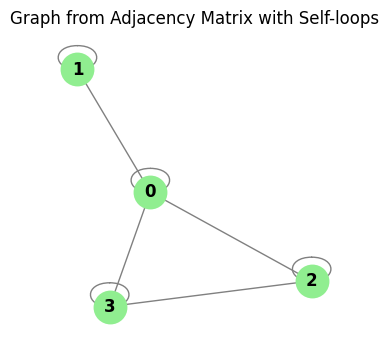

In [4]:
import networkx as nx

G = nx.from_numpy_array(A)

plt.figure(figsize=(3, 3))
nx.draw(G, 
        with_labels=True, 
        node_color='lightgreen', 
        node_size=500, 
        font_weight='bold', 
        edge_color='gray',
        linewidths=2)

plt.title("Graph from Adjacency Matrix with Self-loops")
plt.show()

In [5]:
# setup: node feature matrix
np.random.seed(1)

X = np.random.uniform(-1, 1, (4, 4)) #(low, high (nodes, features))
X

array([[-0.16595599,  0.44064899, -0.99977125, -0.39533485],
       [-0.70648822, -0.81532281, -0.62747958, -0.30887855],
       [-0.20646505,  0.07763347, -0.16161097,  0.370439  ],
       [-0.5910955 ,  0.75623487, -0.94522481,  0.34093502]])

In [6]:
# weight matrix
# Learnable parameter for feature transformation (Dimension: 4 -> 2)
# "Converts raw features into meaningful hidden features."
W = np.random.uniform(-1, 1, (2, 4))
print("Feature Transformation Matrix") # 4->2
print(W)

# Learnable parameter for attention mechanism
# "Calculates the importance score between two nodes."
W_att = np.random.uniform(-1, 1, (1, 4))
print("\nAttention Mechanism Vector")
print(W_att)

# W and W_att will be adjusting by backward process 

Feature Transformation Matrix
[[-0.1653904   0.11737966 -0.71922612 -0.60379702]
 [ 0.60148914  0.93652315 -0.37315164  0.38464523]]

Attention Mechanism Vector
[[ 0.7527783   0.78921333 -0.82991158 -0.92189043]]


In [7]:
# Concatenation of source and target node features for all connected edges

connections = np.where(A > 0)

print(connections)

print("\nStarting: Source node")
print(connections[0])
print("\nArriving: Target node")
print(connections[1])

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

Starting: Source node
[0 0 0 0 1 1 2 2 2 3 3 3]

Arriving: Target node
[0 1 2 3 0 1 0 2 3 0 2 3]


In [8]:
sender_features = (X @ W.T)[connections[0]]
sender_features 

array([[ 1.03693436,  0.53385987],
       [ 1.03693436,  0.53385987],
       [ 1.03693436,  0.53385987],
       [ 1.03693436,  0.53385987],
       [ 0.6589437 , -1.0731773 ],
       [ 0.6589437 , -1.0731773 ],
       [-0.06417521,  0.15131205],
       [-0.06417521,  0.15131205],
       [-0.06417521,  0.15131205],
       [ 0.66050294,  0.83654517],
       [ 0.66050294,  0.83654517],
       [ 0.66050294,  0.83654517]])

In [9]:
receiver_features = (X @ W.T)[connections[1]]
receiver_features

array([[ 1.03693436,  0.53385987],
       [ 0.6589437 , -1.0731773 ],
       [-0.06417521,  0.15131205],
       [ 0.66050294,  0.83654517],
       [ 1.03693436,  0.53385987],
       [ 0.6589437 , -1.0731773 ],
       [ 1.03693436,  0.53385987],
       [-0.06417521,  0.15131205],
       [ 0.66050294,  0.83654517],
       [ 1.03693436,  0.53385987],
       [-0.06417521,  0.15131205],
       [ 0.66050294,  0.83654517]])

In [10]:
# edge representations
# concatenating of sender_features & receiver_features

edge_features = np.concatenate([(X @ W.T)[connections[0]], 
                                (X @ W.T)[connections[1]]], axis=1)

edge_features 

array([[ 1.03693436,  0.53385987,  1.03693436,  0.53385987],
       [ 1.03693436,  0.53385987,  0.6589437 , -1.0731773 ],
       [ 1.03693436,  0.53385987, -0.06417521,  0.15131205],
       [ 1.03693436,  0.53385987,  0.66050294,  0.83654517],
       [ 0.6589437 , -1.0731773 ,  1.03693436,  0.53385987],
       [ 0.6589437 , -1.0731773 ,  0.6589437 , -1.0731773 ],
       [-0.06417521,  0.15131205,  1.03693436,  0.53385987],
       [-0.06417521,  0.15131205, -0.06417521,  0.15131205],
       [-0.06417521,  0.15131205,  0.66050294,  0.83654517],
       [ 0.66050294,  0.83654517,  1.03693436,  0.53385987],
       [ 0.66050294,  0.83654517, -0.06417521,  0.15131205],
       [ 0.66050294,  0.83654517,  0.66050294,  0.83654517]])

In [11]:
# Raw Attention Score (Unnormalized Attention Coefficient)

a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1).T
a

array([[-0.15081312,  1.64439789,  1.11567763, -0.117451  , -1.70365144,
         0.09155957, -1.28161636, -0.0151256 , -1.24825424, -0.19529927,
         1.07119149, -0.16193715]])

In [12]:
# Applying the LeakyReLU activation function to introduce non-linearity
# Passing positive signals and scaling negative ones

def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x, x)

e = leaky_relu(a)
e

array([[-0.03016262,  1.64439789,  1.11567763, -0.0234902 , -0.34073029,
         0.09155957, -0.25632327, -0.00302512, -0.24965085, -0.03905985,
         1.07119149, -0.03238743]])

In [13]:
# back into the adjacency matrix structure

E = np.zeros(A.shape) # A.shape 4*4
E[connections[0], connections[1]] = e[0]
E

array([[-0.03016262,  1.64439789,  1.11567763, -0.0234902 ],
       [-0.34073029,  0.09155957,  0.        ,  0.        ],
       [-0.25632327,  0.        , -0.00302512, -0.24965085],
       [-0.03905985,  0.        ,  1.07119149, -0.03238743]])

In [14]:
# Normalized Attention Coefficients

def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum

W_alpha = softmax2D(E, 1)
W_alpha

array([[0.095345  , 0.50880376, 0.29986793, 0.09598331],
       [0.18682057, 0.28784971, 0.26266486, 0.26266486],
       [0.21800112, 0.28169459, 0.28084372, 0.21946058],
       [0.1644291 , 0.17097876, 0.49906224, 0.16552991]])

In [15]:
# Calculating the final node representations by aggregating weighted neighbor features

H = A.T @ W_alpha @ X @ W.T
H

array([[ 1.91740248, -0.16073368],
       [ 1.01832447, -0.31917017],
       [ 1.37737072, -0.21103129],
       [ 1.37737072, -0.21103129]])

# 2. GAT with Cora dataset

In [ ]:
# Cora dataset, papers as nodes and their citations as edges
from torch_geometric.datasets import Planetoid

# Loading Cora dataset
# Graph Data Download by Planetoid
dataset = Planetoid(root="./cora_data", name="Cora")
data = dataset[0]

print(data)
print(f"Dataset: {dataset}")
print(f" - Nodes: {data.num_nodes}")
print(f" - Edges: {data.num_edges}")
print(f" - Features: {dataset.num_features}")
print(f" - Classes: {dataset.num_classes}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import torch.optim as optim


# 1. GAT Model Class (Architecture)
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        
        # [Layer 1] Multi-head Attention Layer (8 Heads)
        # Input: dim_in (1433 features) -> Output: dim_h * heads (8 * 8 = 64 features)
        # concat=True: Concatenates the outputs from all heads (Standard for hidden layers).
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, concat=True)
        
        # [Layer 2] Output Classification Layer (1 Head)
        # Input: Expanded features from Layer 1 (dim_h * heads)
        # Output: Number of classes (dim_out = 7)
        # concat=False: Averages the outputs (Standard for output layers).
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1, concat=False)

    def forward(self, x, edge_index):
        # [Step 1] Input Dropout (Regularization)
        # Apply dropout to input features to prevent overfitting.
        x = F.dropout(x, p=0.6, training=self.training)
        
        # [Step 2] First GAT Layer (Feature Extraction)
        # Aggregates neighbor information using attention mechanisms.
        x = self.gat1(x, edge_index)
        
        # [Step 3] Activation Function (ELU)
        # Exponential Linear Unit (ELU) is commonly used in GAT models.
        x = F.elu(x)
        
        # [Step 4] Hidden Dropout
        # Apply dropout to hidden representations.
        x = F.dropout(x, p=0.6, training=self.training)
        
        # [Step 5] Second GAT Layer (Classifier)
        # Produces the final class scores (logits).
        x = self.gat2(x, edge_index)
        
        # [Step 6] Log Softmax (Probability)
        # Converts scores into log-probabilities for classification.
        return F.log_softmax(x, dim=1)

In [ ]:
# 3. Setup hyperparameters
torch.manual_seed(1)

# Hyperparameters
dim_in = dataset.num_features   # 1433
dim_h = 8                       # Hidden units per head
dim_out = dataset.num_classes   # 7 Classes
heads = 8                       # 8 Heads

# Model Instantiation
model = GAT(dim_in, dim_h, dim_out, heads)
print("\n[Model Architecture]")
print(model)

# Optimizer & Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Metric Helper
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

In [ ]:
# 4. Training Pipeline
# ==========================================
# Caption: "Functions for training and evaluating the model per epoch."

def train():
    model.train()         # Switch to training mode
    optimizer.zero_grad() # Clear gradients
    
    # Forward pass
    out = model(data.x, data.edge_index)
    
    # Compute loss (using training mask only)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    
    # Backward pass & Optimization
    loss.backward()
    optimizer.step()
    
    # Compute training accuracy
    acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
    return loss.item(), acc.item()

def test():
    model.eval()          # Switch to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        out = model(data.x, data.edge_index)
        
        # [Modified] Calculate Validation Loss as well
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        
        # Evaluate on Validation and Test sets
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        test_acc = accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        
    return val_loss.item(), val_acc.item(), test_acc.item()


In [ ]:
# 5. Starting Training

losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(201):
    loss, train_acc = train()
    val_loss, val_acc, test_acc = test()
    
    # Record metrics
    losses.append(loss)
    val_losses.append(val_loss) # Append validation loss
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Logging
    if epoch % 20 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc*100:.1f}% | Val Acc: {val_acc*100:.1f}%')

# Final Evaluation
_, final_val_acc, final_test_acc = test()
print(f'\nFinal Validation Accuracy: {final_val_acc*100:.2f}%')
print(f'Final Test Accuracy:       {final_test_acc*100:.2f}%')


In [ ]:
# 6. Visualization (Learning Curves)
# Caption: "Visualizing the training/validation loss and accuracy trends over epochs."

plt.figure(figsize=(10, 3))

# Loss Curve (Train vs Validation)
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss', color='red', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2, linestyle='--')
plt.title('Loss Trends (Train vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Accuracy Curve (Train vs Validation)
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', color='blue', linewidth=2)
plt.plot(val_accs, label='Validation Accuracy', color='green', linewidth=2)
plt.title('Accuracy Trends (Train vs. Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.2, 1.2) 
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

# 3. GAT with CiteSeer data

In [ ]:
CiteSeer_dataset = Planetoid(root=".", name="CiteSeer")
CiteSeer_data = CiteSeer_dataset[0]
CiteSeer_data

print(CiteSeer_data)
print(f"Dataset: {CiteSeer_dataset}")
print(f" - Nodes: {CiteSeer_data.num_nodes}")
print(f" - Edges: {CiteSeer_data.num_edges}")
print(f" - Features: {CiteSeer_dataset.num_features}")
print(f" - Classes: {CiteSeer_dataset.num_classes}")

In [ ]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
CiteSeer_degrees = degree(CiteSeer_dataset[0].edge_index[0]).numpy()

# Count the number of nodes for each degree
CiteSeer_numbers = Counter(CiteSeer_degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node CiteSeer_degree')
ax.set_ylabel('Number of CiteSeer_nodes')
plt.bar(CiteSeer_numbers.keys(), CiteSeer_numbers.values())

In [ ]:
# Graph Visualization 

import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

# Convert to NetworkX graph
G = to_networkx(CiteSeer_data, to_undirected=True)

plt.figure(figsize=(10, 10))
plt.title("CiteSeer Citation Network Visualization", fontsize=18)
plt.axis('off')  

# Calculating layout
# k=0.15 controls the distance between nodes (smaller k = tighter clusters)
pos = nx.spring_layout(G, seed=42, k=0.15, iterations=50)

# node drawing
nx.draw_networkx_nodes(G, pos, 
                       node_size=30, 
                       node_color=CiteSeer_data.y, 
                       cmap=plt.cm.Set2,  
                       alpha=0.9)

# edge drawing
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)

# Legend
# CiteSeer dataset typically has 6 classes:
# Agents, AI, DB, IR, ML, HCI
labels_list = ['Agents',    # 0
               'AI',        # 1
               'DB',        # 2
               'IR',        # 3
               'ML',        # 4
               'HCI'        # 5
              ]

# Set2 colormap for 6 classes
colors = plt.cm.Set2(range(6))
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                             label=label, markerfacecolor=color, markersize=10) 
                  for label, color in zip(labels_list, colors)]

plt.legend(handles=legend_handles, title="Paper Class", loc='upper right')

plt.show()

In [ ]:
# 3. Setup & Initialization

torch.manual_seed(1)
CiteSeer_model = GAT(CiteSeer_dataset.num_features, 16, CiteSeer_dataset.num_classes)
print("\n[Model Structure]")
print(CiteSeer_model)

optimizer = optim.Adam(CiteSeer_model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

In [ ]:
# 4. Training Loop (External Functions)
# ==========================================
# [수정 포인트] 모델 내부의 .fit() 대신 직접 루프를 돌립니다.

def train():
    CiteSeer_model.train()
    optimizer.zero_grad()
    out = CiteSeer_model(CiteSeer_data.x, CiteSeer_data.edge_index)
    loss = criterion(out[CiteSeer_data.train_mask], CiteSeer_data.y[CiteSeer_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    CiteSeer_model.eval()
    with torch.no_grad():
        out = CiteSeer_model(CiteSeer_data.x, CiteSeer_data.edge_index)
        pred = out.argmax(dim=1)
        acc = accuracy(pred[CiteSeer_data.test_mask], CiteSeer_data.y[CiteSeer_data.test_mask])
    return acc.item()

print("\n[Starting Training]")
for epoch in range(101):
    loss = train()
    if epoch % 20 == 0:
        test_acc = test()
        print(f'Epoch {epoch:>3} | Loss: {loss:.4f} | Test Acc: {test_acc*100:.2f}%')

final_acc = test()
print(f'\nFinal GAT Test Accuracy: {final_acc*100:.2f}%')



In [ ]:
# Analyzing Performance by Node Degree

# 1. Get model predictions
CiteSeer_model.eval()
with torch.no_grad():
    out = CiteSeer_model(CiteSeer_data.x, CiteSeer_data.edge_index)
    pred = out.argmax(dim=1)

# 2. Calculate degrees
degrees = degree(CiteSeer_data.edge_index[0], num_nodes=CiteSeer_data.num_nodes).numpy()

# 3. Calculate accuracy per degree bucket
accuracies = []
sizes = []
labels = ['0', '1', '2', '3', '4', '5', '6+']

# Degree 0~5
for i in range(6):
    mask = (degrees == i)
    if mask.sum() > 0:
        acc = accuracy(pred[mask], CiteSeer_data.y[mask]).item()
        accuracies.append(acc)
        sizes.append(int(mask.sum()))
    else:
        accuracies.append(0.0)
        sizes.append(0)

# Degree 6+
mask = (degrees >= 6)
if mask.sum() > 0:
    acc = accuracy(pred[mask], CiteSeer_data.y[mask]).item()
    accuracies.append(acc)
    sizes.append(int(mask.sum()))
else:
    accuracies.append(0.0)
    sizes.append(0)

# 4. Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Node Degree (Number of Neighbors)', fontsize=12)
ax.set_ylabel('Accuracy Score', fontsize=12)
ax.set_title('GAT Performance by Node Degree (CiteSeer)', fontsize=14)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Bar plot
bars = ax.bar(labels, accuracies, color='skyblue', edgecolor='black')

# Add text labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    # Accuracy text (Top of bar)
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, 
            f'{accuracies[i]*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Sample size text (Inside bar)
    ax.text(bar.get_x() + bar.get_width()/2., height/2, 
            f'n={sizes[i]}', ha='center', va='center', color='black', fontsize=9)

plt.show()